In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
BASE_DIR = "./"
train = pd.read_parquet(os.path.join(BASE_DIR, "train_basic.parquet"))
test = pd.read_parquet(os.path.join(BASE_DIR, "test_basic.parquet"))

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (10704179, 119), Test shape: (1527298, 119)


In [3]:
# Sequence-based Features
# -----------------------------
for df in [train, test]:
    df['seq_length'] = df['seq'].apply(lambda x: len(str(x).split(',')))
    df['seq_length_log'] = np.log1p(df['seq_length'])
    df['seq_bin'] = pd.cut(
        df['seq_length'], bins=[0,5,10,20,50,100,200,500,1000],
        labels=False, include_lowest=True
    )
    df['new_user_flag'] = (df['seq_length'] <= 5).astype(int)

In [4]:
# 3. Time-based Features
for df in [train, test]:
    df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
    df['day_of_week'] = pd.to_numeric(df['day_of_week'], errors='coerce')

    df['night_flag'] = df['hour'].between(0, 4).astype(int)
    df['tuesday_flag'] = (df['day_of_week'] == 2).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)



In [5]:
# 4. Demographic-based Features
# -----------------------------
for df in [train, test]:
    df['young_flag'] = (df['age_group'] == 1).astype(int)
    df['age_gender_cross'] = df['age_group'].astype(str) + "_" + df['gender'].astype(str)
    df['hour_age_cross'] = df['hour'].astype(str) + "_" + df['age_group'].astype(str)


In [6]:
# 5. CTR-based Features
# -----------------------------
ctr_inventory = train.groupby('inventory_id')['clicked'].mean()
global_ctr = train['clicked'].mean()

for df in [train, test]:
    df['inventory_ctr_enc'] = df['inventory_id'].map(ctr_inventory).fillna(global_ctr)

# 연령대 / 시간대 / 요일별 평균 CTR
ctr_age = train.groupby('age_group')['clicked'].mean()
ctr_hour = train.groupby('hour')['clicked'].mean()
ctr_dow = train.groupby('day_of_week')['clicked'].mean()

for df in [train, test]:
    df['click_ratio_per_age'] = df['age_group'].map(ctr_age)
    df['hour_click_ratio'] = df['hour'].map(ctr_hour)
    df['dow_click_ratio'] = df['day_of_week'].map(ctr_dow)

In [7]:
# 6. Continuous Feature Transformations
# -----------------------------
for df in [train, test]:
    df['feat_e_3_log'] = np.log1p(df['feat_e_3'])
    df['feat_e_3_bin'] = pd.qcut(df['feat_e_3'], q=10, labels=False)
    df['feat_e_3_isna'] = df['feat_e_3'].isnull().astype(int)

# Rank-based feature
train['feat_e_3_rank'] = train['feat_e_3'].rank(pct=True)
train['seq_length_rank'] = train['seq_length'].rank(pct=True)
train['inventory_ctr_rank'] = train['inventory_ctr_enc'].rank(pct=True)

# test는 동일한 scale로 적용 (주의: rank는 train 기준 아님)
for col in ['feat_e_3_rank', 'seq_length_rank', 'inventory_ctr_rank']:
    test[col] = 0  # 추후 모델링 시 제외 가능

In [8]:
# -----------------------------
# 7. Frequency & Historical Features
# -----------------------------
freq_map = train['l_feat_14'].value_counts() / len(train)
hist_cols = [c for c in train.columns if 'history_a_' in c]

for df in [train, test]:
    df['l_feat_14_freq'] = df['l_feat_14'].map(freq_map).fillna(0)
    df['history_mean'] = df[hist_cols].mean(axis=1)


In [9]:
# 8. Activity & Scaling
# -----------------------------
median_seq = train['seq_length'].median()
scaler = StandardScaler()

for df in [train, test]:
    df['seq_activity_flag'] = (df['seq_length'] > median_seq).astype(int)
    df['feat_e_3_scaled'] = scaler.fit_transform(train[['feat_e_3_log']]) \
        if df is train else scaler.transform(test[['feat_e_3_log']])

In [10]:
# 9. Label Encoding for Categorical Features
# -----------------------------
for col in ['inventory_id', 'hour_age_cross', 'age_gender_cross']:
    le = LabelEncoder()
    all_values = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(all_values)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


In [11]:
# 10. Final Feature Set
# -----------------------------
final_features = [
    # continuous / transformed
    'feat_e_3_log', 'feat_e_3_bin', 'feat_e_3_scaled', 'feat_e_3_isna',
    'seq_length', 'seq_length_log', 'seq_bin', 'seq_activity_flag',
    # user & time
    'new_user_flag', 'night_flag', 'tuesday_flag', 'young_flag',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    # categorical encodings
    'inventory_id', 'inventory_ctr_enc',
    'l_feat_14_freq', 'age_gender_cross', 'hour_age_cross',
    # CTR ratios
    'click_ratio_per_age', 'hour_click_ratio', 'dow_click_ratio',
    # historical
    'history_mean'
]

print(f" 최종 Feature 수: {len(final_features)}")
print(f" Example Features:\n{final_features[:10]}")


 최종 Feature 수: 25
 Example Features:
['feat_e_3_log', 'feat_e_3_bin', 'feat_e_3_scaled', 'feat_e_3_isna', 'seq_length', 'seq_length_log', 'seq_bin', 'seq_activity_flag', 'new_user_flag', 'night_flag']


In [12]:
#  Export for Modeling
# -----------------------------
train_fe = train[final_features + ['clicked']].copy()
test_fe = test[final_features].copy()

train_fe.to_parquet("train_featured.parquet", index=False)
test_fe.to_parquet("test_featured.parquet", index=False)
print("Feature Engineering 완료 → Parquet 저장됨")

Feature Engineering 완료 → Parquet 저장됨


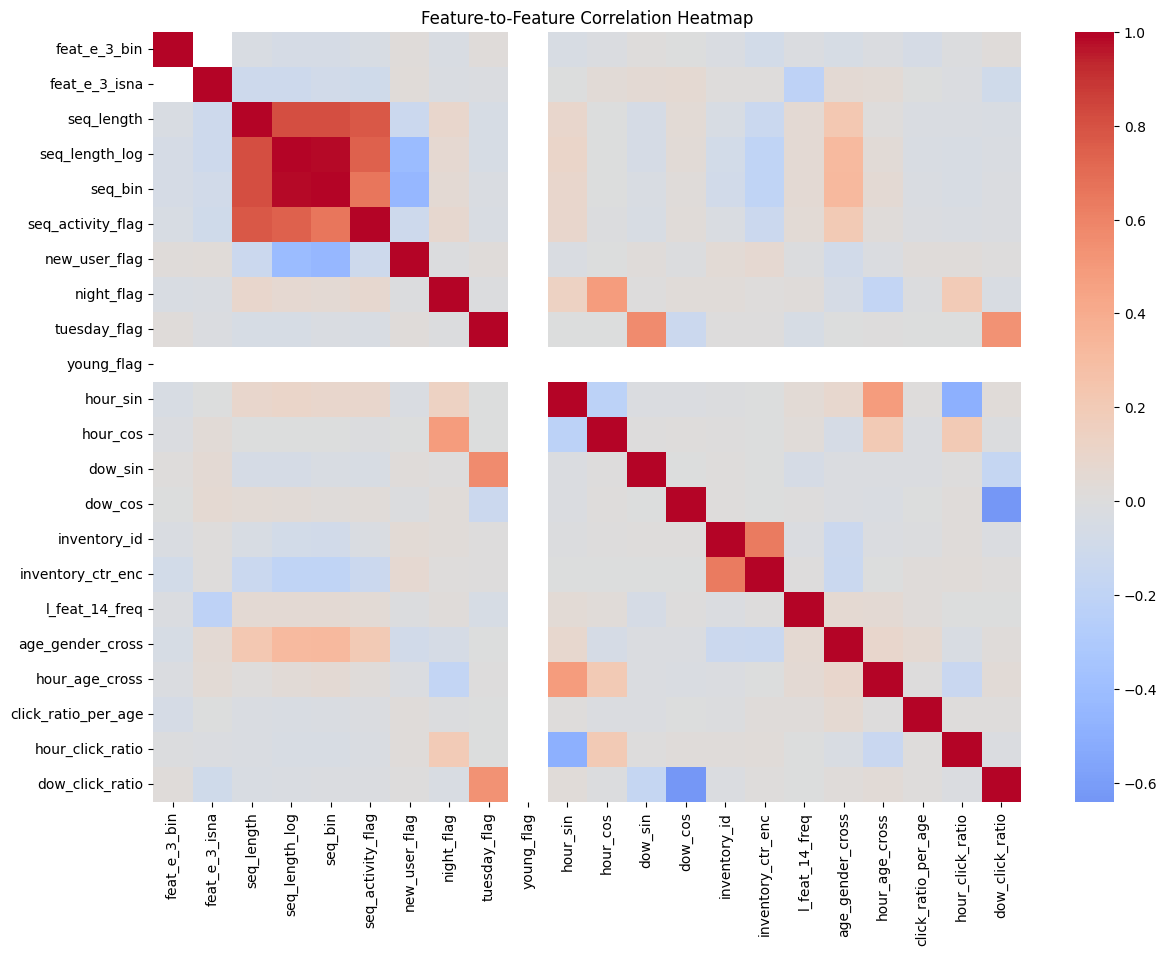

상관계수 0.8 이상인 Feature Pair:
 seq_bin         seq_length_log    0.981006
seq_length_log  seq_bin           0.981006
seq_length      seq_length_log    0.813181
seq_length_log  seq_length        0.813181
seq_bin         seq_length        0.812440
seq_length      seq_bin           0.812440
dtype: float64


In [13]:
# -----------------------------
#  Feature 간 상관관계 분석
# -----------------------------
# 1. numeric feature만 추출
numeric_cols = train_fe.select_dtypes(include=['int64', 'float64']).columns

# 2. 상관계수 계산 (clicked 제외)
corr_matrix = train_fe[numeric_cols].corr()

# 3. 시각화 (히트맵)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature-to-Feature Correlation Heatmap")
plt.show()

# 4. 상관계수 절댓값 기준 Top pairs 보기
corr_unstack = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = corr_unstack[(corr_unstack < 1.0) & (corr_unstack > 0.8)]
print("상관계수 0.8 이상인 Feature Pair:\n", high_corr)

In [14]:

# 1. 숫자형만 추출 (타깃 제외)
X = train_fe.drop(columns=['clicked'])
X_numeric = X.select_dtypes(include=['int64', 'float64']).fillna(0)

# 2. VIF 계산 (속도 위해 샘플링)
sample = X_numeric.sample(100000, random_state=42) if len(X_numeric) > 100000 else X_numeric

vif_data = pd.DataFrame()
vif_data['feature'] = sample.columns
vif_data['VIF'] = [variance_inflation_factor(sample.values, i) for i in range(sample.shape[1])]

# 3. 결과 확인
vif_data = vif_data.sort_values(by='VIF', ascending=False)
display(vif_data)

# 4. 해석 기준
# VIF > 10 → 심한 다중공선성 가능성
# VIF 5~10 → 주의 요망
# VIF < 5 → 대체로 안전


/opt/conda/envs/ml_project/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
21,dow_click_ratio,402.946200
20,hour_click_ratio,347.591247
3,seq_length_log,197.801964
19,click_ratio_per_age,29.776988
2,seq_length,27.182928
17,age_gender_cross,16.146178
4,seq_bin,14.267583
15,inventory_ctr_enc,9.901874
18,hour_age_cross,9.814687
5,seq_activity_flag,6.483625


📊 clicked와의 상관계수 (상위 20개):


clicked                1.000000
inventory_ctr_enc      0.065272
inventory_id           0.041837
click_ratio_per_age    0.026076
history_mean           0.022443
new_user_flag          0.017429
dow_click_ratio        0.010230
hour_click_ratio       0.008805
tuesday_flag           0.005459
hour_cos               0.001851
night_flag             0.001743
age_gender_cross       0.001198
l_feat_14_freq         0.000235
feat_e_3_isna         -0.000065
hour_age_cross        -0.001203
dow_sin               -0.001693
hour_sin              -0.004323
dow_cos               -0.006554
feat_e_3_scaled       -0.013872
feat_e_3_log          -0.013872
Name: clicked, dtype: float64

 clicked와의 상관계수 (상위 20개):


clicked                1.000000
inventory_ctr_enc      0.065272
inventory_id           0.041837
click_ratio_per_age    0.026076
history_mean           0.022443
new_user_flag          0.017429
dow_click_ratio        0.010230
hour_click_ratio       0.008805
tuesday_flag           0.005459
hour_cos               0.001851
night_flag             0.001743
age_gender_cross       0.001198
l_feat_14_freq         0.000235
feat_e_3_isna         -0.000065
hour_age_cross        -0.001203
dow_sin               -0.001693
hour_sin              -0.004323
dow_cos               -0.006554
feat_e_3_scaled       -0.013872
feat_e_3_log          -0.013872
Name: clicked, dtype: float64


 clicked와의 상관계수 (하위 20개):


dow_click_ratio      0.010230
hour_click_ratio     0.008805
tuesday_flag         0.005459
hour_cos             0.001851
night_flag           0.001743
age_gender_cross     0.001198
l_feat_14_freq       0.000235
feat_e_3_isna       -0.000065
hour_age_cross      -0.001203
dow_sin             -0.001693
hour_sin            -0.004323
dow_cos             -0.006554
feat_e_3_scaled     -0.013872
feat_e_3_log        -0.013872
feat_e_3_bin        -0.016255
seq_activity_flag   -0.021613
seq_length          -0.021842
seq_length_log      -0.035198
seq_bin             -0.037362
young_flag                NaN
Name: clicked, dtype: float64

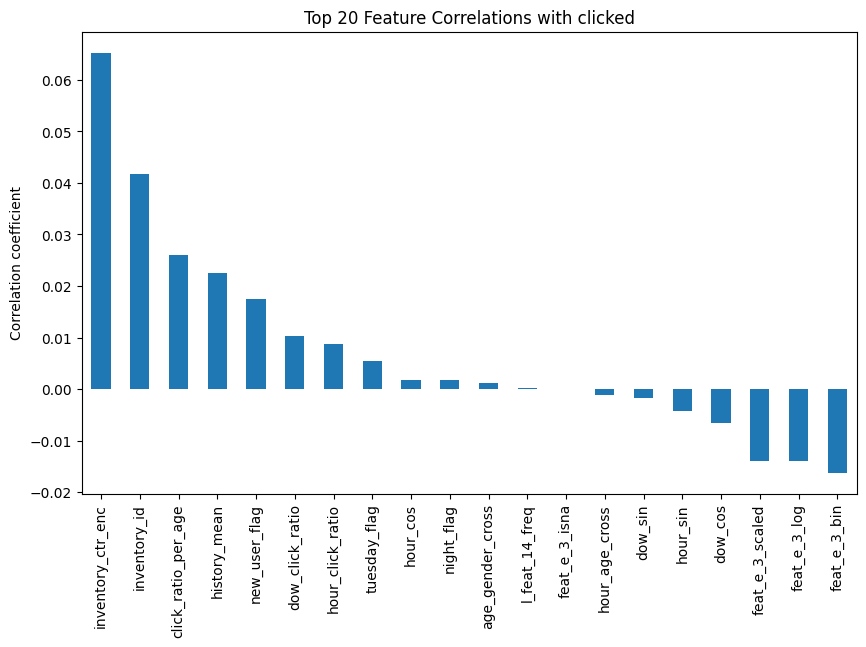

In [19]:
# -----------------------------
#  Target vs Feature 상관관계
# -----------------------------
# 숫자형 feature만 추출
numeric_cols = train_fe.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns


corr_with_target = train_fe[numeric_cols].corr()['clicked'].sort_values(ascending=False)

print("📊 clicked와의 상관계수 (상위 20개):")
display(corr_with_target.head(20))

# clicked와의 상관계수 계산
corr_with_target = train_fe[numeric_cols].corr()['clicked'].sort_values(ascending=False)

# 결과 출력
print(" clicked와의 상관계수 (상위 20개):")
display(corr_with_target.head(20))
print("\n clicked와의 상관계수 (하위 20개):")
display(corr_with_target.tail(20))

# 시각화
plt.figure(figsize=(10,6))
corr_with_target.drop('clicked').sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 Feature Correlations with clicked")
plt.ylabel("Correlation coefficient")
plt.show()


In [21]:
# -----------------------------
# Phase: Feature Selection
# -----------------------------

# 제거 대상 정의
drop_features = [
    'seq_length',             # 원본 길이 (log로 대체)
    'dow_click_ratio',        # 공선성 높음
    'hour_click_ratio'        # 공선성 높음
]

# 필요 시 seq_bin은 유지, 선형모델 병행 시에만 제거 고려
train_input = train_fe.drop(columns=drop_features)
test_input = test_fe.drop(columns=drop_features)

# 확인
print("최종 Feature 수:", len(train_input.columns))
print("clicked 포함 여부:", 'clicked' in train_input.columns)

# 저장
train_input.to_csv("train_input.csv", index=False)
test_input.to_csv("test_input.csv", index=False)
print("train_input.csv / test_input.csv 저장 완료")


최종 Feature 수: 23
clicked 포함 여부: True
train_input.csv / test_input.csv 저장 완료
